# Franklin Wolfe
# EPS 268 - Machine Learning in Geosciences


Damage from earthquakes in California over the last three decades has resulted in over 120 deaths, 500 injuries, and $15 billion in damage; nevertheless, earthquake prediction remains uncertain and unreliable. While the driving force of the earthquake phenomena has been known for decades (the plate boundary interaction between the Pacific and North American Plates) and the seismic moment release has been shown to be clustered in space and time around active faults (>479 segments have been mapped), determining when and where future earthquakes will occur remains challenging (Plesch et al., 2007). This is due to the complex and dynamic nature of the earthquake system present in the region, which has shown examples of dynamic triggering, stress transfer, complex fault geometries, intersecting fault planes, fluid pressure influences, crustal heterogeneity, and local stress state deviations, among many other variables. Additionally, it is possible that our mapping of faults is incomplete, our catalogue of earthquake events is not representative of the entire seismic moment release (e.g., catalogue to brief in time and lacking of small events), and our fundamental theories of earthquake science are flawed (e.g., elastic rebound theory and characteristic earthquake) (Bakun and Lindh, 1985; USGS, 2004; Ross et al., 2019).

The goal of this study is to allow the best datasets of the region to 'speak for themselves'. It is clear that humans are incapable of finding patterns in seismic moment release (i.e., earthquakes); however, it is possible that a neural network designed to identify complex, non-linear interactions could identify a relationship hidden within the noise. If successful, this would greatly impact the state of earthquake science, providing insights into plate boundary-scale fault and earthquake physics.

Ross et al. (2019)'s Quake Template Matching (QTM) seismicity catalogue for Southern California was chosen for this study. The catalogue employed a template-matching detection technique on the entire waveform archive of the regional seismic network of Southern California, which exploited the similarity of earthquake waveforms between nearby events by using the seismograms of previously identified earthquakes as templates and cross-correlated them against the continuous waveform data. The QTM catalogue contains 1.81 million earthquakes, a 10-fold increase over the previous catalogue and a more robust coverage of small magnitude events. Of these, I used nine hundred thousand events that are reliably located. Next, I converted the earthquake event data into a time series by grouping the events that occurred during each day of the catalogue (~10 years total) and then used the magnitude of each event to determine the total seismic energy released during each day of the catalogue. The result was a time-continuous dataset that could potentially reveal hidden patterns in seismic moment release in Southern California. 

Recurrent neural networks (RNN) have a chain-like nature that makes them the natural architecture for sequence and list data, such as earthquake time series data, which is why this type of network was chosen for the study (Olah's Blog, 2015). RNNs can be thought of as a network with multiple copies of the same network, each passing a message to a successor. This allows the network to connect previous information to the present task. Traditional RNNs have an issue with long-term memory (i.e., the networks are only able to connect the most recent information to the present task); however, Long Short-Term Memory (LSTM) networks were developed to solve this long-term dependency problem. Similar to traditional RNNs, LSTM networks consist of a chain-like structure. The difference is within the repeating layer, which contains four components instead of a simple, single component. As new data is fed into the network, the repeating module has 'gates' that decide how to add this information to or update the 'cell state' component. The cell state component acts like a conveyer belt allowing information to move forward in the network (while being modified by new information as determined by the gates). This allows the long-term memory of the system to be updated during each step while information is also being stored for longer terms.

The LSTM network was trained on 80 percent of the data and tested on 20 percent of the data, amounting to 2922 and 731 individual days, respectively. The hyperparameters chosen include: (1) input window of one month, (2) output window of 5 days, (3) stride length of 2 days, (4) hidden size of 15, (5) 1000 epochs, (6) batch size of 32, (5) teacher forcing rate of 0.5, and (6) a learning rate of 0.01. The hidden size was chosen from the empirically-derived-rule-of-thumb suggesting a number between the input and output window quantities. The number of epochs was chosen large to allow ample time for learning. The batch size was chosen to be consistent with a common choice in the literature. The teacher forcing rate was chosen high to speed convergence and reduce instability. Lastly, the learning rate was chosen low to allow for subtle updates to the parameters over many epochs.

As indicated by the loss curve, the LSTM approach initially improved quickly during the initial epochs, but improvements leveled off after roughly 200 epochs. Following this point, the results became unstable and oscillated slightly higher with additional iterations. Unfortunately, the initial improvements to the loss did not result in actual learnings for the algorithm. Instead, the output/prediction was consistently just the mean of the input data. Therefore, this approach was not much better than choosing a moving average over time windows of the dataset and does not (1) predict future earthquakes or (2) daily seismic moment release changes within the output window time frames.

Possible limitations to this approach include but are not limited to the following: (1) it is possible that there are no patterns to find in the data. This system may be too complex and cannot be described by a time-varying signature pattern. (2) The dataset may be incomplete. A large number of earthquakes may exist that are not in the catalog (primarily at smaller magnitudes), the time series may be too short, or the entire system containing a pattern to be found may be much larger spatially than we have investigated (e.g., entire plate boundary must be studies or Basin and Range must be included). (3) It is possible that the data is non-stationary and prone to 'regime changes' which may render aspects of the time series irrelevant for prediction. Events could trigger changes in the baseline state or local stress states of a region which complicate or nullify their inclusion in the long-term patterns. (4) Lastly, the current implementation of the LSTM approach is too time-intensive to identify a potential set of hyper parameters that may lead to better results. The analysis of the final run employed within this study required 50 minutes. This time commitment or more would need to be repeated many times while varying hyper parameters to test the sensitivity of changes to the network.

In conclusion, a specific type of recurrent neural network, termed the long short-term memory network, was used on the most robust earthquake data set available for Southern California with the intention of identifying patterns in seismic moment release and thus predicting future earthquakes. Unfortunately, the network was unsuccessful and earthquake prediction remains an elusive challenge for earth scientists globally.



In [1]:
# Load in necessary functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
cmap = matplotlib.cm.get_cmap('hsv')
from mpl_toolkits import mplot3d      
import matplotlib.ticker as mticker
import seaborn as sns; sns.set()
from sklearn import mixture
from sklearn.cluster import DBSCAN, MiniBatchKMeans, AffinityPropagation
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import time
import warnings
import geopandas as gpd
import earthpy as et
from shapely.geometry import Point
import shapely.geometry as geom
import heapq
import random
import os, errno
import sys
import time
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from sklearn.cluster import KMeans

In [ ]:
# Let's load in the QTM dataset
qtm_df = pd.read_csv('Data/qtm_final_12dev.hypo.csv')
qtm_gpd = gpd.GeoDataFrame(qtm_df, geometry=[Point(x, y) for x, y in zip(qtm_df.LONGITUDE, qtm_df.LATITUDE)])

# Let's load in the Community Fault Model
CFM1 = gpd.read_file('Data/CFM5.2/CFM52_preferred_traces_blind.shp')
CFM2 = gpd.read_file('Data/CFM5.2/CFM52_preferred_traces_nonblind.shp')
CFM_full = pd.concat([CFM1, CFM2],axis=0).reset_index()

In [ ]:
# Set up figure and plot basemap
fig, ax = plt.subplots(figsize = (30,12))
ax.set_aspect('equal')
ax.set_facecolor('white')
world = gpd.read_file('Data/naturalearth_lowres.shp')
base = world.plot(ax=ax,color='black', edgecolor='white')
plt.setp(ax.spines.values(), color='black')
base = world.plot(ax=ax,color='black', edgecolor='white')

# Plot QTM dataset
qtm_gpd.plot(ax=ax)

# Plot CFM 
CFM_full.plot(ax=ax, color='red')

# Set the view limit to only area of interest
ax.set_ylim(32,37.25)
ax.set_xlim(-122,-114.5);

In [ ]:
# Clean and convert time data into time series
qtm_gpd = qtm_gpd.reset_index()

dates = []
for i in np.arange(0,len(qtm_gpd['DAY'])):
    month = qtm_gpd['MONTH'][i]
    day = qtm_gpd['DAY'][i]
    year = qtm_gpd['YEAR'][i]
    
    # Use average days in each month
    if month >= 2:
        month = (month-1)*30.42
    else:
        month = month - 1
        
    # Use average days in each year
    if year >= 2009:
        year = (year-2008) * 365.2422
    else:
        year = year - 2008
    
    date_since_catalog_start = day + month + year
    dates.append(date_since_catalog_start)
    
qtm_gpd['dates_since_start_catalog'] = dates

In [ ]:
# Let's plot the time series
plt.scatter(qtm_gpd['dates_since_start_catalog'],qtm_gpd['MAGNITUDE'])
plt.xlabel('Days')
plt.ylabel('Magnitude')

In [ ]:
# Let's bin on energy released per time
delta_t = 1 # The number of days in each bin
time=[]
energies = []
for i in np.arange(0,max(qtm_gpd['dates_since_start_catalog']),delta_t):
    time.append(i)
    eday = sum(np.exp((qtm_gpd.loc[(qtm_gpd['dates_since_start_catalog'] >= i) & 
                                 (qtm_gpd['dates_since_start_catalog'] < i+delta_t)]['MAGNITUDE'].values)*1.44 + 5.24))
    energies.append(eday)

In [ ]:
# Let's plot this new time series
plt.scatter(time,energies)
plt.xlabel('Time')
plt.ylabel('Energy Release')

In [ ]:
# Let's try out the LSTM approach
time = np.asarray(time)
energies = np.asarray(energies)

In [2]:
# Define functions

# standardize the data

def standardize_data(y_train, y_test):
    train_mean = y_train.mean() 
    train_std = y_train.std() 
    
    y_train_stand = (y_train - train_mean) / train_std
    y_test_stand = (y_test - train_mean) / train_std
    
    return y_train_stand, y_test_stand

# Windowed dataset
def windowed_dataset(y, input_window = 5, output_window = 1, stride = 1, num_features = 1):
    '''
    : param y: time series feature
    : param input_window: number of y samples to give model 
    : param output_window: number of future y samples to predict  
    : param stide: spacing between windows 
    : param num_features: number of features (i.e., 1 for us, but we could have multiple features)
    : return: array with correct dimensions for LSTM (i.e., [# samples, time steps, # features])
    '''
    L = y.shape[0]
    num_samples = (L - input_window - output_window) // stride + 1
    print(num_samples)

    X = np.zeros([input_window, num_samples, num_features])
    Y = np.zeros([output_window, num_samples, num_features])    
    
    for ff in np.arange(num_features):
        for ii in np.arange(num_samples):
            start_x = stride * ii
            end_x = start_x + input_window
            X[:, ii, ff] = y[start_x:end_x, ff]

            start_y = stride * ii + input_window
            end_y = start_y + output_window 
            Y[:, ii, ff] = y[start_y:end_y, ff]

    return X, Y

# split time series into train/test sets 
def train_test_split(t, y, split = 0.8):
  '''
  : param t: time data 
  : para y: feature 
  : para split: percent of data to include in training set
  : return: t/y training/test arrays (shape: [# samples, 1]) 
  '''
  
  indx_split = int(split * len(y))
  indx_train = np.arange(0, indx_split)
  indx_test = np.arange(indx_split, len(y))
  
  # The reshape will put it into an array with the number of elements x 1
  # We need a data cube later when we do the LSTM
  # Array of arrays with just one value in them - 
  # If you had multiple variables going into it you would be able to incorporate this
  t_train = t[indx_train]
  y_train = y[indx_train]
  y_train = y_train.reshape(-1, 1)
  
  t_test = t[indx_test]
  y_test = y[indx_test]
  y_test = y_test.reshape(-1, 1)
  
  return t_train, y_train, t_test, y_test 

# LSTM encoder
  
class lstm_encoder(nn.Module):
    ''' Encodes time-series sequence '''

    def __init__(self, input_size, hidden_size, num_layers = 1):
        '''
        : param input_size: the number of expected features in the input x
        : param hidden_size: the number of features in the hidden state h
        : param num_layers: number of recurrent layers (i.e., 2 means there are
        :                   2 stacked LSTMs)
        '''
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # define LSTM layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)

    def forward(self, x_input):
        '''
        : param x_input: input of shape (seq_len, # in batch, input_size)
        '''
        lstm_out, self.hidden = self.lstm(x_input.view(x_input.shape[0], x_input.shape[1], self.input_size))
        return lstm_out, self.hidden     
    
    def init_hidden(self, batch_size):
        '''
        initialize hidden state
        : param batch_size: x_input.shape[1]
        '''
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))
    
# LSTM decoder

class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        '''
        LSTMCell takes in (batch size, input size/# features)
        : param x_input: should be 2D (batch_size, input_size)
        '''
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(0), encoder_hidden_states)
        output = self.linear(lstm_out.squeeze(0))     
        
        return output, self.hidden

# Tensors are numpy arrays - works the same except they run natively with GPUs
# LSTM functionality

class lstm_seq2seq(nn.Module):
    def __init__(self, input_size, hidden_size):
        
        super(lstm_seq2seq, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)


    def train_model(self, input_tensor, target_tensor, n_epochs, target_len, batch_size, teacher_forcing_ratio, learning_rate = 0.01, dynamic_tf = False):
        '''
        train data using teacher forcing
        : param teacher_forcing_ratio: float [0, 1); high means more teacher forcing 
        '''
        # initialize array of losses 
        losses = np.full(n_epochs, np.nan)
        losses_tf = np.full(n_epochs, np.nan)
        losses_no_tf = np.full(n_epochs, np.nan)


        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.MSELoss()

        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[1] / batch_size)

        # looping through each entire epoch through the training data - through full data set - seen it all at once
        with tnrange(n_epochs) as tr:
            for it in tr:
                
                # training data is separated into batches
                # update the weights after each batch
                batch_loss = 0.
                batch_loss_tf = 0.
                batch_loss_no_tf = 0.
                num_tf = 0
                num_no_tf = 0

                for b in range(n_batches):
                    # select data 
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    target_batch = target_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])

                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)

                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    use_teacher_forcing = ( random.random() < teacher_forcing_ratio )

                    # establish the random chance of teacher forcing in the decoder block
                    if use_teacher_forcing:
                        # teacher forcing: feed the target as the next input
                        for t in range(target_len): 
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            decoder_input = target_batch[t, :, :]

                    else:
                        # predict recursively
                        for t in range(target_len): 
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            decoder_input = decoder_output

                    # compute the loss
                    loss = criterion(outputs, target_batch)

                    batch_loss += loss.item()
                    
                    if use_teacher_forcing:
                        num_tf += batch_size
                        batch_loss_tf += loss.item()
                    else:
                        num_no_tf += batch_size
                        batch_loss_no_tf += loss.item()

                    # Does the entire gradient descent and backpropagation - all derivitives all the way through
                    loss.backward()

                    optimizer.step()

                batch_loss /= (n_batches * batch_size)
                losses[it] = batch_loss

                
                if num_no_tf != 0.: 
                    batch_loss_no_tf /= num_no_tf
                    losses_no_tf[it] = batch_loss_no_tf

                    
                if num_tf !=0:
                    batch_loss_tf /= num_tf
                    losses_tf[it] = batch_loss_tf

                if dynamic_tf and teacher_forcing_ratio > 0:
                    teacher_forcing_ratio = teacher_forcing_ratio - 0.02 
                    
                tr.set_postfix(loss="{0:.3f}".format(batch_loss))
                    
        return losses, losses_tf, losses_no_tf

    def predict(self, input_tensor, target_len):
        '''
        : param input_tensor: (seq_len, input_size)
        '''

        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0)
            decoder_input = decoder_output
            
        np_outputs = outputs.detach().numpy()
        
        return np_outputs

# Plot results
    
def plot_train_test_results(lstm_model, num_rows = 4): 
  num_cols = 2
  num_plots = num_rows * num_cols
# the number of rows is the number of examples I want to show.
  fig, ax = plt.subplots(num_rows, num_cols, figsize = (8, 12))
# add for loop here to plot all of the dimensions ( this is where the 0 is - this is plotting the first dimension)
  for ii in range(num_rows):
      # train set
      X_train_plt = X_train[:, ii, :]
      Y_train_pred = lstm_model.predict(X_train_plt, target_len = ow)
      ax[ii, 0].plot(np.arange(0, iw), Xtrain[:, ii, 0], 'k', label = 'Input')
      ax[ii, 0].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtrain[-1, ii, 0]], Ytrain[:, ii, 0]]), 'b', label = 'Target')
      ax[ii, 0].plot(np.arange(iw - 1, iw + ow),  np.concatenate([[Xtrain[-1, ii, 0]], Y_train_pred[:, 0]]), 'r', label = 'Prediction')
      ax[ii, 0].set_xlabel('t')
      ax[ii, 0].set_ylabel('y')


      # test set
      X_test_plt = X_test[:, ii, :]
      Y_test_pred = lstm_model.predict(X_test_plt, target_len = ow)
      ax[ii, 1].plot(np.arange(0, iw), Xtest[:, ii, 0], 'k', label = 'Input')
      ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtest[-1, ii, 0]], Ytest[:, ii, 0]]), 'b', label = 'Target')
      ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtest[-1, ii, 0]], Y_test_pred[:, 0]]), 'r', label = 'Prediction')
      ax[ii, 1].set_xlabel('t')
      ax[ii, 1].set_ylabel('y')

      if ii == 0:
        ax[ii, 0].set_title('Train')
        
        ax[ii, 1].legend(bbox_to_anchor=(1, 1))
        ax[ii, 1].set_title('Test')

        
  return 

In [64]:
# Train test split
t_train, y_train, t_test, y_test = train_test_split(time, energies, split = 0.8)

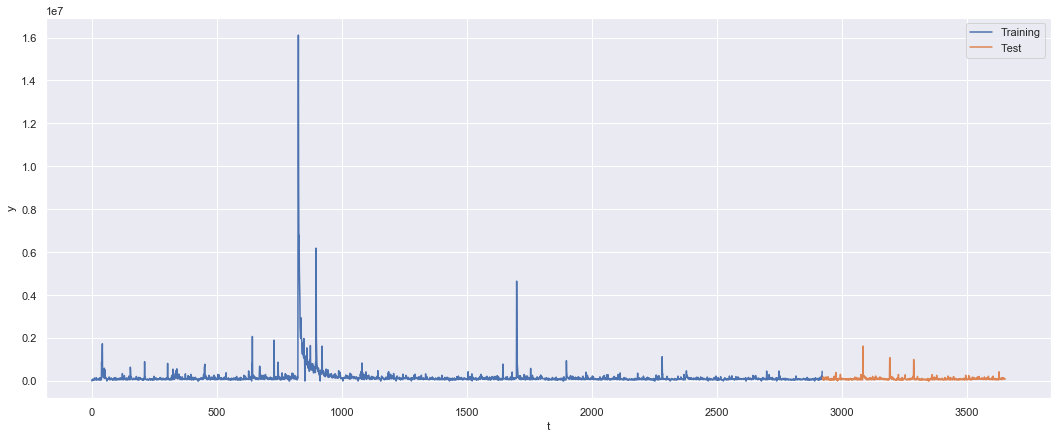

In [66]:
# plot train/test data
plt.figure(figsize=(18,7))
plt.plot(t_train,y_train,label = 'Training')
plt.plot(t_test,y_test,label = 'Test')
plt.xlabel('t')
plt.ylabel('y')
plt.legend(loc=1)
plt.show()

In [68]:
# Standardize
y_train_stand, y_test_stand = standardize_data(y_train, y_test)

(2.9180399825876805e-17, 1.0)

In [70]:
# generate windowed training/test datasets
iw = 30 # input window
ow = 5 # output window
s = 2 # stride

Xtrain, Ytrain = windowed_dataset(y_train_stand, input_window = iw, output_window = ow, stride = s)
Xtest, Ytest = windowed_dataset(y_test_stand, input_window = iw, output_window = ow, stride = s)

1444
349


In [43]:
# check the shape of the data 

print(f'Xtrain has shape {Xtrain.shape} and Ytrain has shape {Ytrain.shape}')
print(f'Xtest has shape {Xtest.shape} and Ytest has shape {Ytest.shape}')

Xtrain has shape (30, 1444, 1) and Ytrain has shape (5, 1444, 1)
Xtest has shape (30, 349, 1) and Ytest has shape (5, 349, 1)


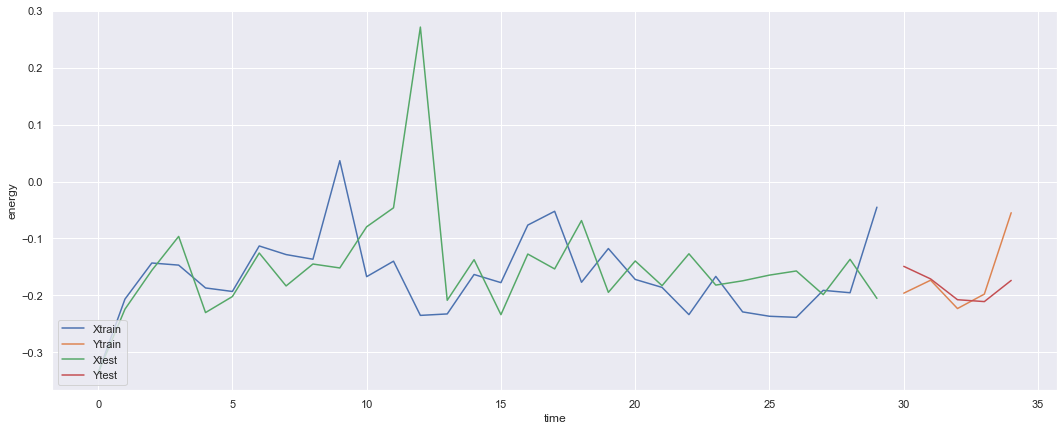

In [52]:
# plot an example in the windowed data 

time_i = 30
plt.figure(figsize=(18,7))
plt.plot(Xtrain[:,time_i,0],label = 'Xtrain')
plt.plot(np.arange(iw,iw+ow),Ytrain[:,time_i,0],label = 'Ytrain')
plt.plot(Xtest[:,time_i,0],label = 'Xtest')
plt.plot(np.arange(iw,iw+ow),Ytest[:,time_i,0],label = 'Ytest')
plt.xlabel('time')
plt.ylabel('energy')
plt.legend(loc=3)
plt.show()

In [77]:
# We make these numpy arrays into torch arrays so they can backpropagate

# the data needs to be in a torch format, not np.array
X_train = torch.from_numpy(Xtrain).type(torch.Tensor)
Y_train = torch.from_numpy(Ytrain).type(torch.Tensor)

X_test = torch.from_numpy(Xtest).type(torch.Tensor)
Y_test = torch.from_numpy(Ytest).type(torch.Tensor)
input_size = X_train.shape[2]

# specify model parameters and train 
hidden_size = 15   # how much memory 
n_epochs = 1000      # num of times going through full dataset 
batch_size = 10     # how many windowed examples you look at before changing the weights 
teacher_forcing_ratio = 0.9 
lr = 0.01         
# Dynamic TF True of false, change it 


model = lstm_seq2seq(input_size = input_size, hidden_size = hidden_size)
loss, loss_tf, loss_no_tf = model.train_model(X_train, Y_train, n_epochs = n_epochs, target_len = ow, batch_size = 5, teacher_forcing_ratio = teacher_forcing_ratio, learning_rate = lr, dynamic_tf = False)


Text(0, 0.5, 'Loss')

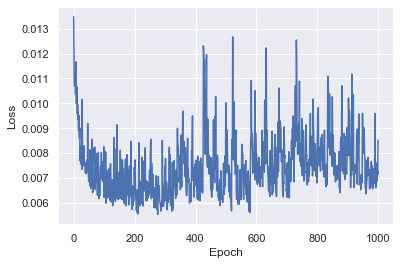

In [81]:
# Plot loss
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')

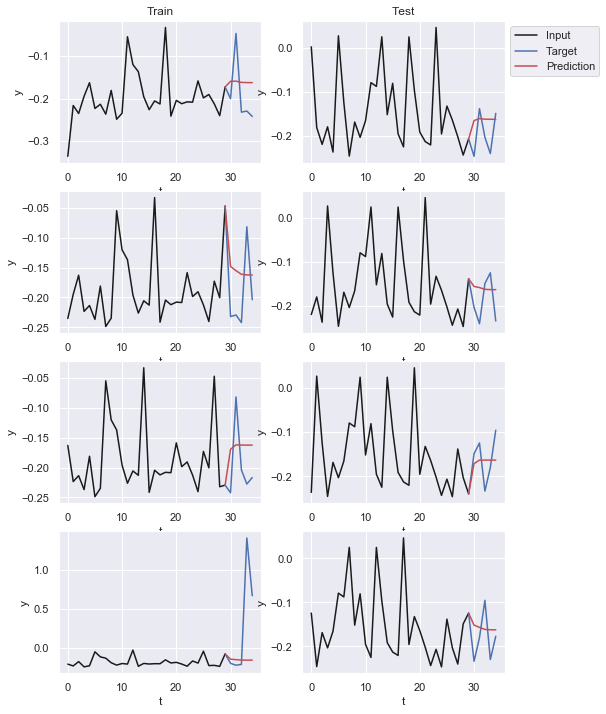

In [80]:
# plot results
plot_train_test_results(model)

# Works Referenced: 

Ross et al., Science 364, 767-771 (2019)

Plesch et al., BSSA 97, 1793-1802 (2007)

Olah, Christopher, Understanding LSTM Networks, Olah’s Blog, Github, (2015)

Numerous articles on www.machinelearning.com

Numerous articles on www.towardsdatascience.com

Numerous articles on www.medium.com

“The Parkfield, California, Earthquake Experiment”. USGS: Science for a Changing World Website. Web. (2004).

Bakun, W.H., and Lindh, A.G., Science 229, 619-624 (1985).

Laura Kulowski